In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from random import choices

In [2]:
from dotenv import load_dotenv
load_dotenv(dotenv_path='/Users/daniel/OAN/SID/.env')

True

In [3]:
from OSMPythonTools.api import Api
# Tool to search OSM data by name and address
from OSMPythonTools.nominatim import Nominatim
# read-only API that serves up custom selected parts of the OSM map data
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from shapely.geometry import Point, Polygon

In [4]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from time import sleep

In [5]:
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
from oauth2client import file,client, tools
from googleapiclient import discovery
from httplib2 import Http
## CONECTION TO DRIVE

SCOPES = ['https://www.googleapis.com/auth/drive'
        ]
store = file.Storage('/Users/daniel/OAN/credentials/storage.json')
creds = store.get()
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('/Users/daniel/OAN/credentials/credentials.json', SCOPES)
    creds = tools.run_flow(flow, store)
drive_service = discovery.build('drive', 'v3', http=creds.authorize(Http()))

In [6]:
def upload_to_drive(file,filename,mimetype,folder_id):
    
    
    #metadatos del archivo
    file_metadata = {
        'name': filename,
        'parents': folder_id
    }
    media = MediaFileUpload(file,
                            mimetype=mimetype,
                            resumable=True)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        supportsAllDrives=True,
                                        fields='id').execute()
    return file.get('id')

In [7]:
#https://www.johndcook.com/blog/python_longitude_latitude/
def distance_on_unit_sphere(lat1, long1, lat2, long2):
    # Convert latitude and longitude to
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians

    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    # Compute spherical distance from spherical coordinates.

    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) =
    # sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length

    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
    math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )

    # Remember to multiply arc by the radius of the earth
    # in your favorite set of units to get length.
    return arc

In [8]:
def display(img):
    img_dis = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    f = plt.figure(figsize=(15,8))
    plt.imshow(img_dis)

### SISTEMATIC

In [9]:
overpass = Overpass()

In [10]:
nominatim = Nominatim()
murcia = nominatim.query('Murcia')
id_murcia = murcia.areaId()

In [11]:
id_murcia

3600340611

In [12]:
query = overpassQueryBuilder(area=id_murcia,
                             elementType='way',
                             selector=['"natural"="water"','"water"="reservoir"'],
                             out='geom')

In [13]:
req = overpass.query(query)

In [14]:
balsas_json = req.toJSON()

In [15]:
df_balsas = pd.DataFrame(balsas_json['elements'])

In [16]:
df_balsas.shape

(201, 6)

In [17]:
#### landuse reservoir

In [18]:
query_reservoir = overpassQueryBuilder(area=id_murcia,
                             elementType='way',
                             selector=['"landuse"="reservoir"'],
                             out='geom')

In [19]:
req_reservoir = overpass.query(query_reservoir)

In [20]:
reservoir_json = req_reservoir.toJSON()

In [21]:
df_reservoir = pd.DataFrame(reservoir_json['elements'])

In [22]:
df_reservoir.shape

(223, 6)

In [23]:
query_water = overpassQueryBuilder(area=id_murcia,
                             elementType='way',
                             selector=['"natural"="water"'],
                             out='geom')

In [24]:
req_water = overpass.query(query_water)

In [25]:
water_json = req_water.toJSON()

In [26]:
df_water = pd.DataFrame(water_json['elements'])

In [27]:
df_water.shape

(386, 6)

In [28]:
(df_balsas.shape,df_reservoir.shape,df_water.shape)

((201, 6), (223, 6), (386, 6))

In [29]:
df_all = df_balsas.append(df_reservoir
                         ).append(df_water
                                 ).drop_duplicates(subset=['id']
                                                  ).reset_index(drop=True)

In [30]:
df_all.shape

(609, 6)

In [31]:
def get_data(x):
    geo_df = pd.DataFrame(x)
    poly = Polygon(zip(geo_df['lon'], geo_df['lat']))
    point = Point(poly.centroid.x, poly.centroid.y)
    boudary_lat = str(geo_df['lat'].tolist())
    boudary_lon = str(geo_df['lon'].tolist())
    ret = pd.Series([
        str(poly.centroid.y),               # lat
        str(poly.centroid.x),               # lon
        str(poly.length),       # perim
        str(poly.area),        # area
        boudary_lat,                        # boudary_lat
        boudary_lon,                        # boudary_lon
        poly,                               # polygon
        point                             # point
    ])

    return ret
    

In [32]:
df_all[[
    'lat',
    'lon',
    'length',
    'area',
    'boudary_lat',
    'boudary_lon',
    'poly',
    'point'
]]=df_all['geometry'
         ].apply(lambda x: get_data(x))

In [33]:
edit_url = 'https://www.openstreetmap.org/edit?way='

In [34]:
df_all['link'] = df_all['id'].apply(lambda x: edit_url+str(x))

In [35]:
df_all.shape

(609, 15)

In [36]:
df_all.head()

type         id                                             bounds  \
0  way  107695740  {'minlat': 37.8822136, 'minlon': -0.9263595, '...   
1  way  107696149  {'minlat': 37.904989, 'minlon': -0.8946879, 'm...   
2  way  107696150  {'minlat': 37.8919477, 'minlon': -0.9250698, '...   
3  way  107696151  {'minlat': 37.9054884, 'minlon': -0.8940871, '...   
4  way  107696152  {'minlat': 37.9042017, 'minlon': -0.8939798, '...   

                                               nodes  \
0  [1237260914, 1237260907, 1237260918, 123726089...   
1  [1237261852, 1237261831, 1237261857, 123726184...   
2  [1237261871, 1237261861, 1237261833, 123726186...   
3  [1237261834, 1237261846, 1237261836, 123726183...   
4  [1237261851, 1237261855, 1237261867, 123726184...   

                                            geometry  \
0  [{'lat': 37.8822136, 'lon': -0.9255655}, {'lat...   
1  [{'lat': 37.9055985, 'lon': -0.8946879}, {'lat...   
2  [{'lat': 37.8926069, 'lon': -0.9250698}, {'lat...   
3  [{'lat': 37.9063265, 'lon': -0.8940871}, {'lat...   
4  [{'lat': 37.9053191, 'lon': -0.8932288}, {'lat...   

                                         tags                lat  \
0  {'natural': 'water', 'water': 'reservoir'}  37.88274858659921   
1  {'natural': 'water', 'water': 'reservoir'}  37.90549543163201   
2  {'natural': 'water', 'water': 'reservoir'}         37.8926435   
3  {'natural': 'water', 'water': 'reservoir'}  37.90618122433148   
4  {'natural': 'water', 'water': 'reservoir'}   37.9047603028882   

                   lon                 length                    area  \
0  -0.9256646837013344  0.0037392418467269433   8.762912800004094e-07   
1  -0.8940138194229069   0.003360536845325937   6.754615149985241e-07   
2  -0.9241884500000002   0.004496640973379229   1.229367079998398e-06   
3  -0.8933033407618807   0.004152377367430913  1.0606731449962616e-06   
4  -0.8932684281994774   0.003695617085054836   8.199902999984269e-07   

                                         boudary_lat  \
0  [37.8822136, 37.8826031, 37.8832636, 37.882984...   
1  [37.9055985, 37.904989, 37.9053953, 37.9059963...   
2  [37.8926069, 37.8919477, 37.8926801, 37.893339...   
3  [37.9063265, 37.9054884, 37.9059963, 37.906876...   
4  [37.9053191, 37.904608, 37.9042017, 37.9049212...   

                                         boudary_lon  \
0  [-0.9255655, -0.9249111, -0.9255226, -0.926359...   
1  [-0.8946879, -0.8940228, -0.8933576, -0.893969...   
2  [-0.9250698, -0.9241491, -0.9233071, -0.924227...   
3  [-0.8940871, -0.8932825, -0.8925744, -0.893218...   
4  [-0.8932288, -0.8925422, -0.8933361, -0.893979...   

                                                poly  \
0  POLYGON ((-0.9255655 37.8822136, -0.9249111 37...   
1  POLYGON ((-0.8946879 37.9055985, -0.8940228 37...   
2  POLYGON ((-0.9250698000000001 37.8926069, -0.9...   
3  POLYGON ((-0.8940871 37.9063265, -0.8932825 37...   
4  POLYGON ((-0.8932288 37.9053191, -0.8925422 37...   

                                           point  \
0  POINT (-0.9256646837013344 37.88274858659921)   
1  POINT (-0.8940138194229069 37.90549543163201)   
2         POINT (-0.9241884500000002 37.8926435)   
3  POINT (-0.8933033407618807 37.90618122433148)   
4   POINT (-0.8932684281994774 37.9047603028882)   

                                               link  
0  https://www.openstreetmap.org/edit?way=107695740  
1  https://www.openstreetmap.org/edit?way=107696149  
2  https://www.openstreetmap.org/edit?way=107696150  
3  https://www.openstreetmap.org/edit?way=107696151  
4  https://www.openstreetmap.org/edit?way=107696152

### begin driver selenium

In [37]:
driver = webdriver.Chrome(executable_path=
                          r'/Users/daniel/OAN/SID/chromedriver')

In [38]:
link = df_all['link'].values[0]

In [39]:
driver.get(link)
sleep(2)

In [40]:
username = 'd.alfaro@oaninternational.org'
password = os.environ['OSM_PASS']

In [41]:
driver.find_element_by_id('username').send_keys(username)
sleep(2)

In [42]:
driver.find_element_by_id('password').send_keys(password)
sleep(2)

In [43]:
driver.find_element_by_name('commit').click()
sleep(3)

In [44]:
driver.refresh()

### BEGIN EXTRACTION

In [45]:
#just_first_time
image_datas = []
balsas_in_pics = []

In [157]:
pantalla = input('Que pantalla')
if pantalla == 'g':
    desfase = 51
    y_1 = 74
    y_n = 920
    x_0 = 0
    x_n = 1880
    const =  2 * math.pi * earth_radius /256
    
else:
    desfase = 100
    #filter
    y_1 = 250-desfase
    y_n = 1380-desfase
    x_0 = 0
    x_n = 2480
    const =  math.pi * earth_radius /256

Que pantallag


In [ ]:
begin_n = 0

for i_l,n_bal in enumerate(df_all['id'].to_list()[begin_n:]):
    baaal = i_l + begin_n
    #GET VILLAGE DATA
    bal_row = df_all[df_all['id']==n_bal]
    bal_lat = round(float(bal_row['lat'].values[0]),5)
    bal_lon = round(float(bal_row['lon'].values[0]),5)
    bal_zoom = 17

    #OPEN PICTURE
    link = 'https://www.openstreetmap.org/edit?#map='
    link = link + str(bal_zoom)+'/'+str(bal_lat)+'/'+str(bal_lon)
    driver.get(link)
    sleep(1)
    driver.get(link)
    sleep(1)


    l_layer=input('WHAT LAYER ARE YOU USING')
    layer = 'pnoa'

    if l_layer == 'm':
        layer='maxar'

    elif l_layer == 'e':
        layer='esri'

    elif l_layer == 'b':
        layer='bing'

    elif l_layer == 'x':
        layer='mapbox'

    elif l_layer == 'p':
        layer='pnoa'

    else:
        layer=l_layer
    
    #SAVE PICTURE
    bal_zoom = int(driver.current_url.split('=')[1].split('/')[0])
    bal_lon = float(driver.current_url.split('/')[-1])
    bal_lat = float(driver.current_url.split('/')[-2])
    sleep(3)
    image_file = '/Users/daniel/OAN/SID/balsas/osm/balsa_'+str(n_bal)+'_ss.png'
    driver.save_screenshot(image_file)

    img = cv2.imread(image_file)
    
    
    img_2 = img[desfase:,:,].copy()
    #CONVERSION DATA
    earth_radius= 6378137
    d_lat = distance_on_unit_sphere(bal_lat, bal_lon, bal_lat+1, bal_lon)*earth_radius
    d_lon = distance_on_unit_sphere(bal_lat, bal_lon, bal_lat, bal_lon+1)*earth_radius

    m_per_px = const * math.cos(bal_lat * math.pi / 180) / math.pow(2, 17)
    deg_per_m_lat = 1 / (d_lat)
    deg_per_m_lon = 1 / (d_lon)

    img_size_deg_lat = m_per_px * deg_per_m_lat * img_2.shape[0]  # m/px * deg/m * px = deg
    img_size_deg_lon = m_per_px * deg_per_m_lon * img_2.shape[1]  # m/px * deg/m * px = deg

    lat_0 = bal_lat + (img_size_deg_lat / 2)
    lon_0 = bal_lon - (img_size_deg_lon / 2)

    deg_per_px_lat = deg_per_m_lat*m_per_px
    deg_per_px_lon = deg_per_m_lon*m_per_px

    
    img_corr = img_2[y_1:y_n,x_0:x_n,:].copy()
    
    image_file_corr = '/Users/daniel/OAN/SID/balsas/osm/balsa_'+str(n_bal)+'.png'
    cv2.imwrite(image_file_corr,img_corr)

    drive_id = upload_to_drive(image_file_corr,
                           'balsa_'+str(n_bal)+'.png',
                           'image/png',
                           ['18OyJR8tvXpXWf-X6Pd-oiTSGIO6GRCAX'])
    

    balsas_in_pic_vill = []
    
    balsa_dict = df_all.T.to_dict()

    for i in balsa_dict:
        balsa = balsa_dict[i]
        lat = float(balsa['lat'])
        lon = float(balsa['lon'])
        boudary_lat = eval(balsa['boudary_lat'])
        boudary_lon = eval(balsa['boudary_lon'])

        #pic_data of house
        lat_px = (lat_0 - lat) / deg_per_px_lat
        lon_px = (lon - lon_0) / deg_per_px_lon
        house = [[(float(lonn) - lon_0) / deg_per_px_lon,(lat_0 - float(latt)) / deg_per_px_lat]
                 for latt,lonn in zip(boudary_lat,boudary_lon)
                ]
        #update_data
        balsa_dict[i]['house'] = house
        balsa_dict[i]['lat_px'] = int(lat_px)
        balsa_dict[i]['lon_px'] = int(lon_px)

        lat_pxs.append(lat_px)
        lon_pxs.append(lon_px)

        filt = (y_1 < lat_px) & (lat_px < y_n) & (x_0 < lon_px) & (lon_px < x_n) 

        if filt:
            house_corr = [[(float(lonn) - lon_0) / deg_per_px_lon,((lat_0 - float(latt)) / deg_per_px_lat) - y_1]
                 for latt,lonn in zip(boudary_lat,boudary_lon)
                ]

            balsa_pic = {
                'drive_id':drive_id,
                #'drive_id':n_bal,
                'id':balsa['id'],
                'house':house_corr,
                'lat_px':int(round(lat_px,0))  - y_1,
                'lon_px':int(round(lon_px,0))
            }
            balsas_in_pics.append(balsa_pic)
            balsas_in_pic_vill.append(balsa_pic)

    image_data ={
        'drive_id':drive_id,
        #'drive_id':n_bal,
        'path':image_file_corr,
        'lat_0':lat_0,
        'lon_0':lon_0,
        'deg_per_px_lat':deg_per_px_lat,
        'deg_per_px_lon':deg_per_px_lon,
        'n_houses':len(balsas_in_pic_vill),
        'layer':layer
    }

    for balsa in balsas_in_pic_vill:

        lat_px = balsa['lat_px']
        lon_px = balsa['lon_px']
        house = balsa['house']

        cv2.circle(img_corr, (int(lon_px), int(lat_px)), 4, (0, 255, 0), -1)
        vertices = np.array(house,dtype=np.int32)
        pts = vertices.reshape((-1,1,2))
        cv2.polylines(img_corr,[pts],isClosed=True,color=(0,0,255),thickness=4)

    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(img_corr,cv2.COLOR_BGR2RGB))
    plt.title(str(n_bal)+' N- {} \n houses ={}'.format(baaal,len(balsas_in_pic_vill)))
    plt.show()
    correction = input('Data correct [y|n]')
    
    if correction == 'y':
        image_datas.append(image_data)
    elif correction == 'n':
        continue
    else:
        break

## SAVE DATA

In [165]:
df_balsas = pd.DataFrame(balsas_in_pics)

In [166]:
df_balsas.shape

(974, 5)

In [167]:
df_balsas.to_gbq('water_zones.image_ds','sidhouses')

1it [00:02,  2.80s/it]


In [168]:
df_images = pd.DataFrame(image_datas)

In [169]:
df_images.shape

(102, 8)

In [170]:
df_images.to_gbq('water_zones.image_ds_info','sidhouses')

1it [00:03,  3.31s/it]


## FIRST TIME

In [49]:
n_bal = df_all.iloc[1]['id']

In [50]:
#GET VILLAGE DATA
bal_row = df_all[df_all['id']==n_bal]
bal_lat = round(float(bal_row['lat'].values[0]),5)
bal_lon = round(float(bal_row['lon'].values[0]),5)
bal_zoom = 17

#OPEN PICTURE
link = 'https://www.openstreetmap.org/edit?#map='
link = link + str(bal_zoom)+'/'+str(bal_lat)+'/'+str(bal_lon)
driver.get(link)
sleep(1)
driver.get(link)
sleep(1)

In [51]:
l_layer=input('WHAT LAYER ARE YOU USING')
layer = 'pnoa'

if l_layer == 'm':
    layer='maxar'

elif l_layer == 'e':
    layer='esri'

elif l_layer == 'b':
    layer='bing'

elif l_layer == 'x':
    layer='mapbox'
    
elif l_layer == 'p':
    layer='pnoa'

else:
    layer=l_layer

WHAT LAYER ARE YOU USINGp


In [54]:
#SAVE PICTURE
bal_zoom = int(driver.current_url.split('=')[1].split('/')[0])
bal_lon = float(driver.current_url.split('/')[-1])
bal_lat = float(driver.current_url.split('/')[-2])
(bal_zoom,bal_lon,bal_lat)

(17, -0.89616, 37.9055)

In [55]:
sleep(3)
image_file = '/Users/daniel/OAN/SID/balsas/osm/balsa_'+str(n_bal)+'_ss.png'
driver.save_screenshot(image_file)

True

In [56]:
img = cv2.imread(image_file)

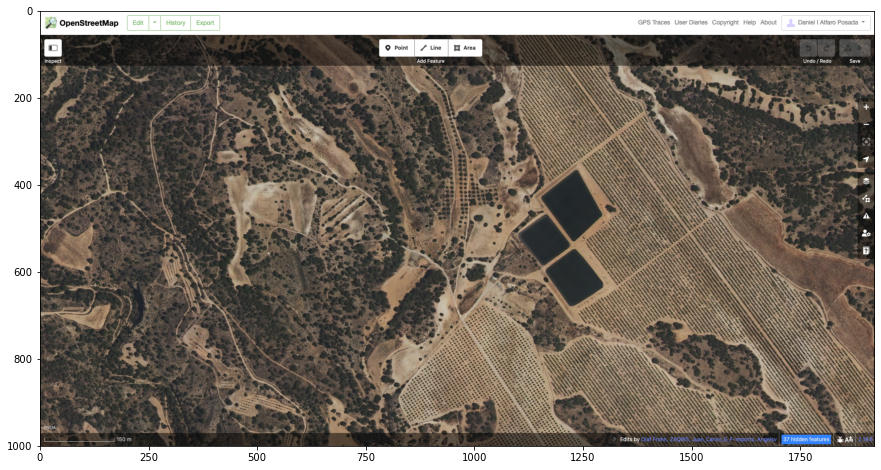

In [57]:
display(img)

In [62]:
desfase = 51
img_2 = img[desfase:,:,].copy()

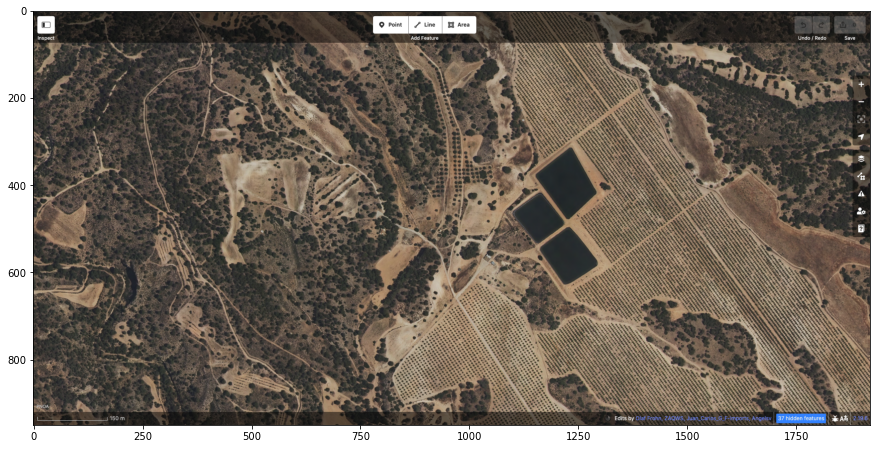

In [63]:
display(img_2)

In [317]:
#y_0 = img.shape[0]-948
#display(img[y_0:,:,:]) 

In [155]:
#CONVERSION DATA
earth_radius= 6378137
d_lat = distance_on_unit_sphere(bal_lat, bal_lon, bal_lat+1, bal_lon)*earth_radius
d_lon = distance_on_unit_sphere(bal_lat, bal_lon, bal_lat, bal_lon+1)*earth_radius

const =  2 * math.pi * earth_radius /256
#const =  math.pi * earth_radius /256
m_per_px = const * math.cos(bal_lat * math.pi / 180) / math.pow(2, 17)
deg_per_m_lat = 1 / (d_lat)
deg_per_m_lon = 1 / (d_lon)

img_size_deg_lat = m_per_px * deg_per_m_lat * img_2.shape[0]  # m/px * deg/m * px = deg
img_size_deg_lon = m_per_px * deg_per_m_lon * img_2.shape[1]  # m/px * deg/m * px = deg

lat_0 = bal_lat + (img_size_deg_lat / 2)
lon_0 = bal_lon - (img_size_deg_lon / 2)

deg_per_px_lat = deg_per_m_lat*m_per_px
deg_per_px_lon = deg_per_m_lon*m_per_px

In [146]:
y_1 = 74
y_n = 920
x_0 = 0
x_n = 1880

In [147]:
(y_1,y_n,x_0,x_n)

(74, 920, 0, 1880)

In [148]:
img_2.shape

(950, 1920, 3)

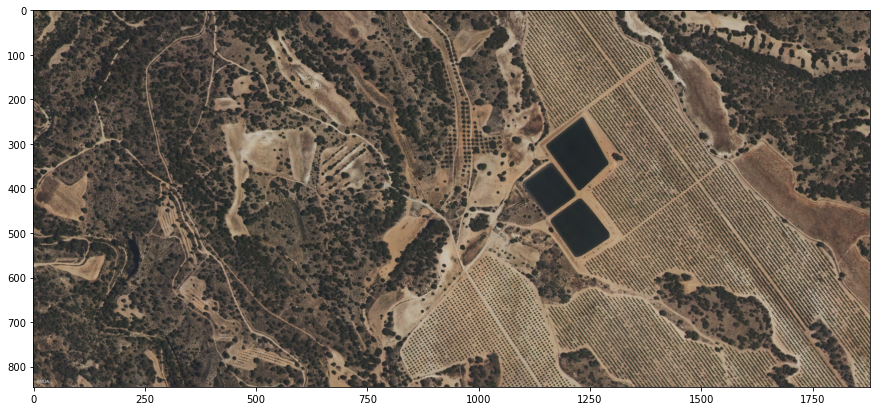

In [151]:
display(img_2[y_1:y_n,x_0:x_n,:])

In [152]:
img_corr = img_2[y_1:y_n,x_0:x_n,:].copy()

In [153]:
image_file_corr = '/Users/daniel/OAN/SID/balsas/osm/balsa_'+str(n_bal)+'.png'
cv2.imwrite(image_file_corr,img_corr)

drive_id = upload_to_drive(image_file_corr,
                       'balsa_'+str(n_bal)+'.png',
                       'image/png',
                       ['18OyJR8tvXpXWf-X6Pd-oiTSGIO6GRCAX'])


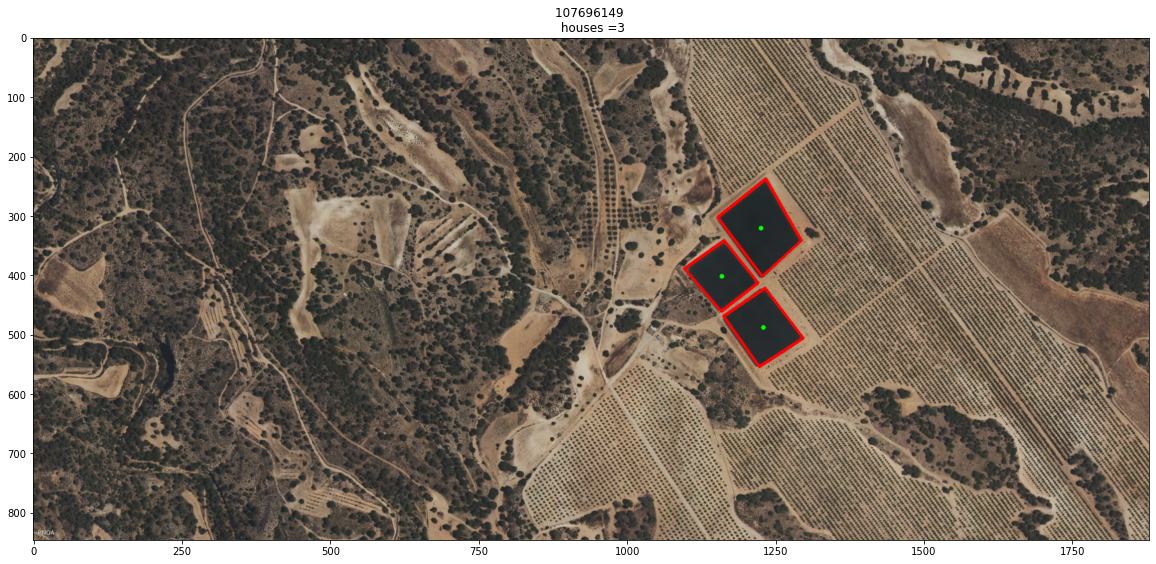

In [156]:
img_corr = img_2[y_1:y_n,x_0:x_n,:].copy()
balsas_in_pic_vill = []
new_balsa_data = []
balsas_in_pic = []
image_datas = []
lat_pxs = []
lon_pxs = []


balsa_dict = df_all.T.to_dict()

for i in balsa_dict:
    balsa = balsa_dict[i]
    lat = float(balsa['lat'])
    lon = float(balsa['lon'])
    boudary_lat = eval(balsa['boudary_lat'])
    boudary_lon = eval(balsa['boudary_lon'])

    #pic_data of house
    lat_px = (lat_0 - lat) / deg_per_px_lat
    lon_px = (lon - lon_0) / deg_per_px_lon
    house = [[(float(lonn) - lon_0) / deg_per_px_lon,(lat_0 - float(latt)) / deg_per_px_lat]
             for latt,lonn in zip(boudary_lat,boudary_lon)
            ]
    #update_data
    balsa_dict[i]['house'] = house
    balsa_dict[i]['lat_px'] = int(lat_px)
    balsa_dict[i]['lon_px'] = int(lon_px)
    
    lat_pxs.append(lat_px)
    lon_pxs.append(lon_px)
    
    filt = (y_1 < lat_px) & (lat_px < y_n) & (x_0 < lon_px) & (lat_px < x_n) 

    if filt:
        house_corr = [[(float(lonn) - lon_0) / deg_per_px_lon,((lat_0 - float(latt)) / deg_per_px_lat) -y_1]
             for latt,lonn in zip(boudary_lat,boudary_lon)
            ]

        balsa_pic = {
            'drive_id':120,
            'id':balsa['id'],
            'house':house_corr,
            'lat_px':int(round(lat_px,0)) -y_1,
            'lon_px':int(round(lon_px,0))
        }
        balsas_in_pic.append(balsa_pic)
        balsas_in_pic_vill.append(balsa_pic)

image_data ={
    'drive_id':120,
    'path':image_file_corr,
    'lat_0':lat_0,
    'lon_0':lon_0,
    'deg_per_px_lat':deg_per_px_lat,
    'deg_per_px_lon':deg_per_px_lon,
    'n_houses':len(balsas_in_pic_vill),
    'layer':layer
}

for balsa in balsas_in_pic_vill:

    lat_px = balsa['lat_px']
    lon_px = balsa['lon_px']
    house = balsa['house']

    cv2.circle(img_corr, (int(lon_px), int(lat_px)), 4, (0, 255, 0), -1)
    vertices = np.array(house,dtype=np.int32)
    pts = vertices.reshape((-1,1,2))
    cv2.polylines(img_corr,[pts],isClosed=True,color=(0,0,255),thickness=4)

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img_corr,cv2.COLOR_BGR2RGB))
plt.title(str(n_bal)+' \n houses ={}'.format(len(balsas_in_pic_vill)))
plt.show()